# SALES PREDICTION USING ARIMA AND PROPHET FOR BRAZILIAN E-COMMERCE

The dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

**What is ARIMA model?**

A. ARIMA(Auto Regressive Integrated Moving Average) is a combination of 2 models AR(Auto Regressive) & MA(Moving Average). It has 3 hyperparameters - P(auto regressive lags),d(order of differentiation),Q(moving avg.) which respectively comes from the AR, I & MA components. The AR part is correlation between prev & current time periods. To smooth out the noise, the MA part is used. The I part binds together the AR & MA parts.

# 📤 IMPORT LIBRARIES

In [ ]:
!pip install statsmodels
!pip install pmdarima

In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from scipy import stats
import os
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from pylab import rcParams

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from xgboost import  XGBRegressor

# elimina os warnings das bibliotecas
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 💾 CHECK OUT THE DATA

In [3]:
df_item = pd.read_csv("dataset/olist_order_items_dataset.csv")
df_reviews = pd.read_csv("dataset/olist_order_reviews_dataset.csv")
df_orders = pd.read_csv("dataset/olist_orders_dataset.csv")
df_products = pd.read_csv("dataset/olist_products_dataset.csv")
df_geolocation = pd.read_csv("dataset/olist_geolocation_dataset.csv")
df_sellers = pd.read_csv("dataset/olist_sellers_dataset.csv")
df_order_pay = pd.read_csv("dataset/olist_order_payments_dataset.csv")
df_customers = pd.read_csv("dataset/olist_customers_dataset.csv")
df_category = pd.read_csv("dataset/product_category_name_translation.csv")

**ALL IN ONE**

In [4]:
# merge all the tables in one dataframe
df_train = df_orders.merge(df_item, on='order_id', how='left')
df_train = df_train.merge(df_order_pay, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(df_reviews, on='order_id', how='outer')
df_train = df_train.merge(df_products, on='product_id', how='outer')
df_train = df_train.merge(df_customers, on='customer_id', how='outer')
df_train = df_train.merge(df_sellers, on='seller_id', how='outer')

**CONVERT DATE COLUMNS TO TIMESTAMP**

In [5]:
df_train['order_purchase_time'] = pd.to_datetime(df_train['order_purchase_timestamp']).dt.time

In [6]:
# Extracting attributes for purchase date - Date
df_train['order_purchase_timestamp'] = pd.to_datetime(df_train['order_purchase_timestamp']).dt.date
df_train['order_delivered_customer_date'] = pd.to_datetime(df_train['order_delivered_customer_date']).dt.date
df_train['order_estimated_delivery_date'] = pd.to_datetime(df_train['order_estimated_delivery_date']).dt.date
df_train['order_approved_at'] = pd.to_datetime(df_train['order_approved_at']).dt.date
df_train['order_delivered_carrier_date'] = pd.to_datetime(df_train['order_delivered_carrier_date']).dt.date

In [7]:
# Extracting attributes for purchase date - Year and Month
df_train['order_purchase_year'] = pd.to_datetime(df_train['order_purchase_timestamp']).dt.year
df_train['order_purchase_month'] = pd.to_datetime(df_train['order_purchase_timestamp']).dt.month
df_train['order_purchase_month_name'] = df_train['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))

In [8]:
# Extracting attributes for purchase date - Day and Day of Week
df_train['order_purchase_day'] = pd.to_datetime(df_train['order_purchase_timestamp']).apply(lambda x: x.day)
df_train['order_purchase_dayofweek'] = pd.to_datetime(df_train['order_purchase_timestamp']).apply(lambda x: x.dayofweek)
df_train['order_purchase_dayofweek_name'] = pd.to_datetime(df_train['order_purchase_timestamp']).dt.day_name()

In [9]:
df_train['order_purchase_timestamp'] = pd.to_datetime(df_train['order_purchase_timestamp'])
df_train['order_purchase_time'] = pd.to_datetime(df_train['order_purchase_time'],format='%H:%M:%S').dt.time
df_train['order_delivered_customer_date'] = pd.to_datetime(df_train['order_delivered_customer_date'])
df_train['order_estimated_delivery_date'] = pd.to_datetime(df_train['order_estimated_delivery_date'])


In [10]:
df_train.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,seller_zip_code_prefix,seller_city,seller_state,order_purchase_time,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,9350.0,maua,SP,10:56:00,2017,10,Oct,2,0,Monday
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,9350.0,maua,SP,10:56:00,2017,10,Oct,2,0,Monday
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,9350.0,maua,SP,10:56:00,2017,10,Oct,2,0,Monday
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15,2017-08-15,2017-08-17,2017-08-18,2017-08-28,1.0,87285b34884572647811a353c7ac498a,...,9350.0,maua,SP,18:29:00,2017,8,Aug,15,1,Tuesday
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02,2017-08-02,2017-08-04,2017-08-07,2017-08-15,1.0,87285b34884572647811a353c7ac498a,...,9350.0,maua,SP,18:24:00,2017,8,Aug,2,2,Wednesday


In [11]:
df_train_state=df_train

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119143 entries, 0 to 119142
Data columns (total 46 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       119143 non-null  object        
 1   customer_id                    119143 non-null  object        
 2   order_status                   119143 non-null  object        
 3   order_purchase_timestamp       119143 non-null  datetime64[ns]
 4   order_approved_at              118966 non-null  object        
 5   order_delivered_carrier_date   117057 non-null  object        
 6   order_delivered_customer_date  115722 non-null  datetime64[ns]
 7   order_estimated_delivery_date  119143 non-null  datetime64[ns]
 8   order_item_id                  118310 non-null  float64       
 9   product_id                     118310 non-null  object        
 10  seller_id                      118310 non-null  object        
 11  

CLEAN DATA

In [ ]:
df_train.shape

<iframe src="https://www.kaggle.com/embed/fekmea/preparation-olist-dataset/notebook?cellIds=10&kernelSessionId=80861728" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Preparation Olist dataset"></iframe>

In [13]:
df_train.isnull().sum().sort_values(ascending = False).head()

review_comment_title             105154
review_comment_message            68898
order_delivered_customer_date      3421
product_photos_qty                 2542
product_description_lenght         2542
dtype: int64

In [14]:
# We may drop the review_comment_title column, as all values are null
df_train.drop(['review_comment_title'], axis=1, inplace=True)

Default review comment message

In [15]:
df_train['review_comment_message'] = df_train['review_comment_message'].fillna('No message')

In [16]:
df_train.isnull().sum().sort_values(ascending = False)

order_delivered_customer_date    3421
product_photos_qty               2542
product_description_lenght       2542
product_name_lenght              2542
product_category_name            2542
order_delivered_carrier_date     2086
review_answer_timestamp           997
review_creation_date              997
review_score                      997
review_id                         997
product_width_cm                  853
product_height_cm                 853
product_length_cm                 853
product_weight_g                  853
seller_zip_code_prefix            833
seller_state                      833
seller_city                       833
seller_id                         833
order_item_id                     833
freight_value                     833
product_id                        833
price                             833
shipping_limit_date               833
order_approved_at                 177
payment_type                        3
payment_installments                3
payment_sequ

Drop nan values

In [17]:
df_train_0 = df_train.shape[0]
#Remove missing values with dropna
df_train= df_train.dropna()
df_train_1 = df_train.shape[0]
print(f'{round(((df_train_0-df_train_1)/df_train_1)*100,2)}% nan values points were eliminated')

5.24% nan values points were eliminated


# VISUALIZATION

# Price Distribution

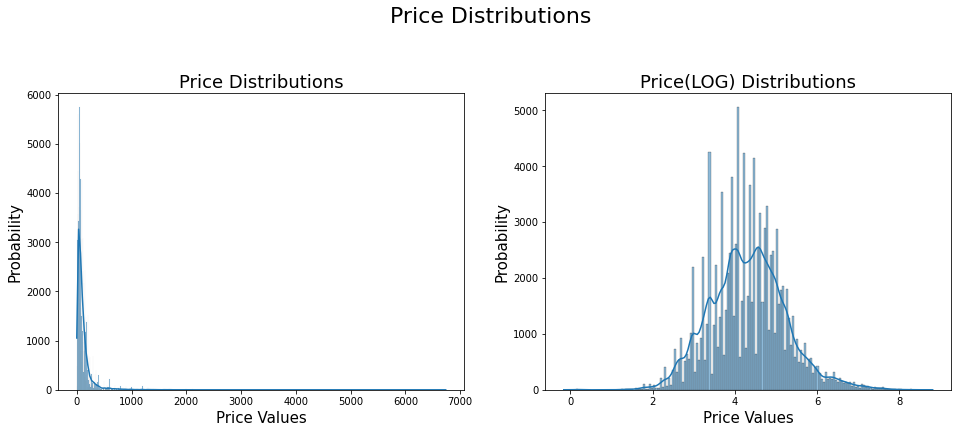

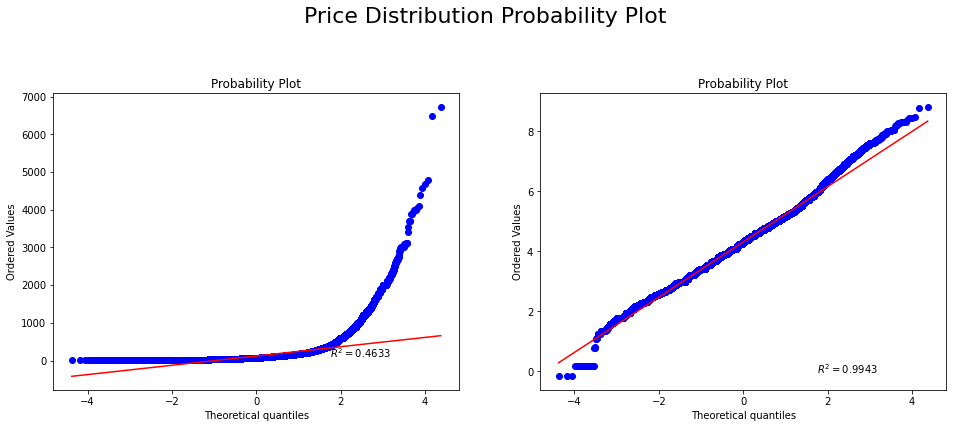

In [18]:
# Getting the histogram and normal probability plot
plt.figure(figsize=(16,12))
plt.suptitle('Price Distributions', fontsize=22)
plt.subplot(221)
g = sns.histplot(df_train['price'], kde=True)
g.set_title("Price Distributions", fontsize=18)
g.set_xlabel("Price Values", fontsize=15)
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.histplot(np.log(df_train['price']), kde=True)
g1.set_title("Price(LOG) Distributions", fontsize=18)
g1.set_xlabel("Price Values", fontsize=15)
g1.set_ylabel("Probability", fontsize=15)

plt.show()

plt.figure(figsize=(16,12))

plt.suptitle('Price Distribution Probability Plot', fontsize=22)

plt.subplot(221)
res = stats.probplot(df_train['price'], plot=plt, fit=True, rvalue=True);


plt.subplot(222)
res = stats.probplot(np.log(df_train['price']), plot=plt, fit=True, rvalue=True);

plt.show()

**Price Distribution:**
Histogram of a sample from a right-skewed distribution – it looks unimodal and skewed right.

**Price Log Distribution:**
Histogram of a sample from a normal distribution – it looks fairly symmetric and unimodal.

**Probability Plot - Price Distribution:**
Normal probability plot of a sample from a right-skewed distribution – it has an inverted C shape.

**Probability Plot - Price Log Distribution:**
Normal probability plot of a sample from a normal distribution – it looks fairly straight, at least when the few large and small values are ignored.

Let's Check the Features Through the Time

Our current timestamps can be tricky to work with, so we'll be using the average daily price amount for that month, and we're using the start of each month as the timestamp.

In [19]:
df_train['order_purchase_timestamp'].min(), df_train['order_purchase_timestamp'].max()

(Timestamp('2016-10-03 00:00:00'), Timestamp('2018-08-29 00:00:00'))

In [20]:
df_train = df_train.groupby('order_purchase_timestamp')['price'].sum().reset_index()
df_train

,order_purchase_timestamp,price
0,2016-10-03,463.48
1,2016-10-04,9093.20
2,2016-10-05,6329.57
3,2016-10-06,5889.96
4,2016-10-07,6205.25
...,...,...
606,2018-08-25,10711.93
607,2018-08-26,8235.71
608,2018-08-27,5343.67
609,2018-08-28,3757.51


**Indexing with Time Series of Data**

In [21]:
df_train=df_train.set_index('order_purchase_timestamp')
df_train.index

DatetimeIndex(['2016-10-03', '2016-10-04', '2016-10-05', '2016-10-06',
               '2016-10-07', '2016-10-08', '2016-10-09', '2016-10-10',
               '2016-12-23', '2017-01-05',
               ...
               '2018-08-20', '2018-08-21', '2018-08-22', '2018-08-23',
               '2018-08-24', '2018-08-25', '2018-08-26', '2018-08-27',
               '2018-08-28', '2018-08-29'],
              dtype='datetime64[ns]', name='order_purchase_timestamp', length=611, freq=None)

In [22]:
sales = df_train['price'].resample('MS').mean()
sales2=sales[3:]
sales

order_purchase_timestamp
2016-10-01     5207.490000
2016-11-01             NaN
2016-12-01       10.900000
2017-01-01     4315.034074
2017-02-01     8377.728571
2017-03-01    11936.762581
2017-04-01    11666.186000
2017-05-01    16652.321935
2017-06-01    14596.793667
2017-07-01    16454.247742
2017-08-01    18475.442258
2017-09-01    21188.403333
2017-10-01    21160.312903
2017-11-01    33600.196667
2017-12-01    23486.290000
2018-01-01    30148.913548
2018-02-01    30374.145714
2018-03-01    31326.676774
2018-04-01    33160.559000
2018-05-01    32363.670968
2018-06-01    29863.889667
2018-07-01    28464.616774
2018-08-01    29693.637586
Freq: MS, Name: price, dtype: float64

# **Viewing Furniture Sales Time Series Data**

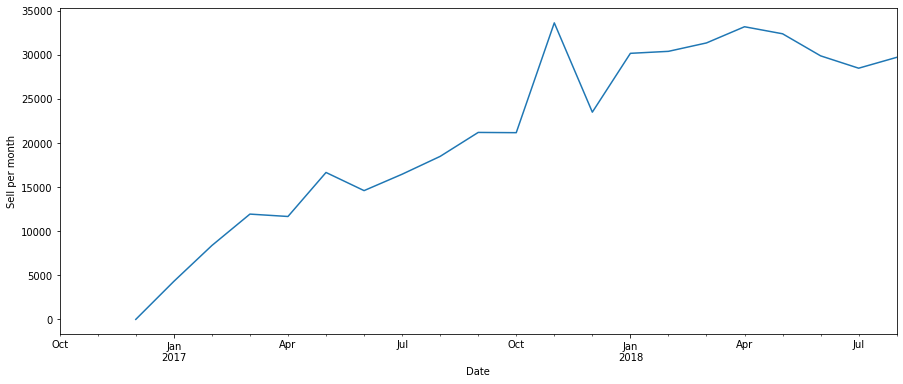

In [23]:
sales.plot(figsize=(15, 6))
plt.xlabel('Date')
plt.ylabel('Sell per month')
plt.show()

In [24]:
#Determine rolling statistics
sales_mean = sales.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
sales_std = sales.rolling(window=12).std()
print(sales_mean,sales_std)

order_purchase_timestamp
2016-10-01             NaN
2016-11-01             NaN
2016-12-01             NaN
2017-01-01             NaN
2017-02-01             NaN
2017-03-01             NaN
2017-04-01             NaN
2017-05-01             NaN
2017-06-01             NaN
2017-07-01             NaN
2017-08-01             NaN
2017-09-01             NaN
2017-10-01             NaN
2017-11-01    14869.527478
2017-12-01    16825.809978
2018-01-01    18978.633267
2018-02-01    20811.668029
2018-03-01    22427.494212
2018-04-01    24218.691962
2018-05-01    25527.971048
2018-06-01    26800.229048
2018-07-01    27801.093134
2018-08-01    28735.942745
Freq: MS, Name: price, dtype: float64 order_purchase_timestamp
2016-10-01            NaN
2016-11-01            NaN
2016-12-01            NaN
2017-01-01            NaN
2017-02-01            NaN
2017-03-01            NaN
2017-04-01            NaN
2017-05-01            NaN
2017-06-01            NaN
2017-07-01            NaN
2017-08-01            NaN
2017-

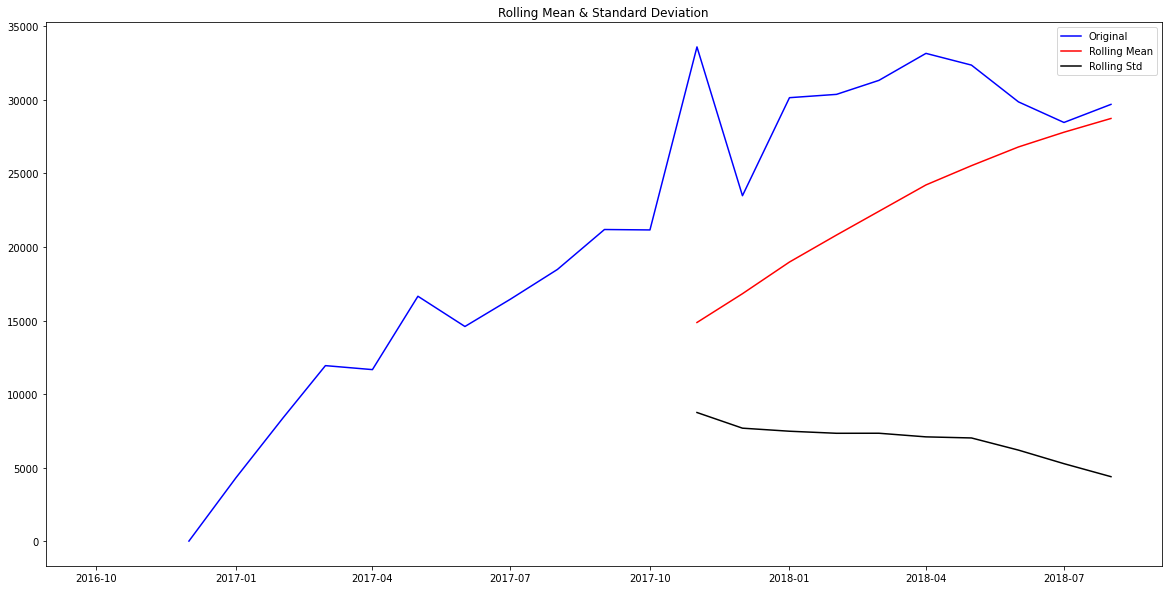

In [25]:
#Plot rolling statistics
plt.figure(figsize=(20,10))
orig = plt.plot(sales, color='blue', label='Original')
sales_mean = plt.plot(sales_mean, color='red', label='Rolling Mean')
sales_std = plt.plot(sales_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [26]:
# Primeiro, vamos decompor a série pra avaliar tendência
# Sazonalidade e resíduo
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df_train)

fig = plt.figure(figsize=(8, 6))  
fig = resultado.plot()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

Teste de estacionariedade

In [27]:
# Teste de estacionariedade. 
# A hipótese nula é que a série não é estacionária
# Ou seja, se o p-valor for menor que 0,05, rejeitamos
# que a série não é estacionária. Caso seja maior, não podemos
# descartar que a série não é estacionária
from statsmodels.tsa.stattools import adfuller

result=adfuller(df['producao'].dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

NameError: name 'df' is not defined

# ARIMA Model for Time Series Forecasting

Let's apply one of the most used methods for forecasting time series, known as ARIMA, which stands Autoregressive Integrated Moving Average.

ARIMA models are denoted with the ARIMA notation (p, d, q). These three parameters are responsible for the seasonality, trend and noise in the data:

In [28]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [29]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sales,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            #enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue           


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:506.32045986199176
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:504.1005389052709
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:251.4520073310609
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:250.50841193365721
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:504.50902233318914
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:504.8661721339813
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:247.38349262635393
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:498.49760028938954
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:500.1865988080026
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:244.57740416532073
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:245.74020159316444
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:500.17465771258554
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:502.17465222195983
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:245.34663082821467
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:247.34663022480711
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:415.3940556818162
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:416.10228858687935
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:200.595060922470

In [30]:
mod = sm.tsa.statespace.SARIMAX(sales2,
                                order=(1, 1, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_invertibility=False)
results = mod.fit(disp=False)
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1534      0.525     -0.292      0.770      -1.183       0.876
sigma2      9.347e+06   8.86e+06      1.055      0.291   -8.01e+06    2.67e+07


In [31]:
results.plot_diagnostics(variable=0, lags=2, figsize=10)
plt.show()

TypeError: Value after * must be an iterable, not int

A saída acima sugere que o SARIMAX (0, 1, 0) x (1, 1, 0, 12) produz o menor valor de AIC de 4.0. Portanto, devemos considerar isso como a melhor opção.

# Adjusting the ARIMA model

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                   23
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -204.473
Date:                Wed, 05 Jan 2022   AIC                            414.947
Time:                        17:45:44   BIC                            418.220
Sample:                    10-01-2016   HQIC                           415.718
                         - 08-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5389      0.577     -0.934      0.351      -1.670       0.593
ma.L1          0.1526      0.624      0.245      0.807      -1.070       1.375
sigma2       1.59e+07   3.73e+06      4.263      0.0

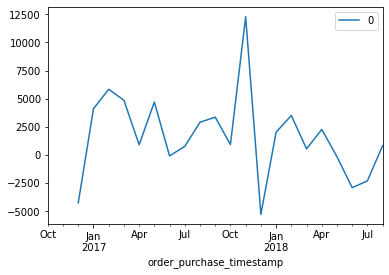

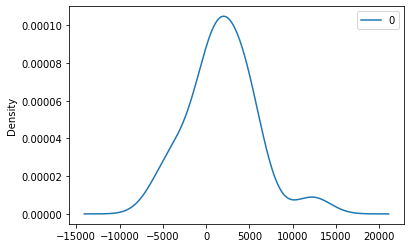

                  0
count     22.000000
mean    1819.018375
std     3818.095158
min    -5284.767390
25%       70.065219
50%     1470.019200
75%     3956.642081
max    12284.127095


In [32]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
# fit model
model = ARIMA(sales, order=(1,1,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

**Customer's State Distribution**

In [33]:
df_train_state

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,seller_zip_code_prefix,seller_city,seller_state,order_purchase_time,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,9350.0,maua,SP,10:56:00,2017,10,Oct,2,0,Monday
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,9350.0,maua,SP,10:56:00,2017,10,Oct,2,0,Monday
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,9350.0,maua,SP,10:56:00,2017,10,Oct,2,0,Monday
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15,2017-08-15,2017-08-17,2017-08-18,2017-08-28,1.0,87285b34884572647811a353c7ac498a,...,9350.0,maua,SP,18:29:00,2017,8,Aug,15,1,Tuesday
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02,2017-08-02,2017-08-04,2017-08-07,2017-08-15,1.0,87285b34884572647811a353c7ac498a,...,9350.0,maua,SP,18:24:00,2017,8,Aug,2,2,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,1ab38815794efa43d269d62b98dae815,a0b67404d84a70ef420a7f99ad6b190a,delivered,2018-07-01,2018-07-05,2018-07-04,2018-07-09,2018-07-20,1.0,31ec3a565e06de4bdf9d2a511b822b4d,...,13660.0,porto ferreira,SP,10:23:00,2018,7,Jul,1,6,Sunday
119139,b159d0ce7cd881052da94fa165617b05,e0c3bc5ce0836b975d6b2a8ce7bb0e3e,canceled,2017-03-11,2017-03-11,NaT,NaT,2017-03-30,1.0,241a1ffc9cf969b27de6e72301020268,...,89031.0,blumenau,SC,19:51:00,2017,3,Mar,11,5,Saturday
119140,735dce2d574afe8eb87e80a3d6229c48,d531d01affc2c55769f6b9ed410d8d3c,delivered,2018-07-24,2018-07-24,2018-07-24,2018-08-02,2018-08-16,1.0,1d187e8e7a30417fda31e85679d96f0f,...,13478.0,americana,SP,09:46:00,2018,7,Jul,24,1,Tuesday
119141,25d2bfa43663a23586afd12f15b542e7,9d8c06734fde9823ace11a4b5929b5a7,delivered,2018-05-22,2018-05-22,2018-05-24,2018-06-12,2018-06-08,1.0,6e1c2008dea1929b9b6c27fa01381e90,...,8320.0,sao paulo,SP,21:13:00,2018,5,May,22,1,Tuesday


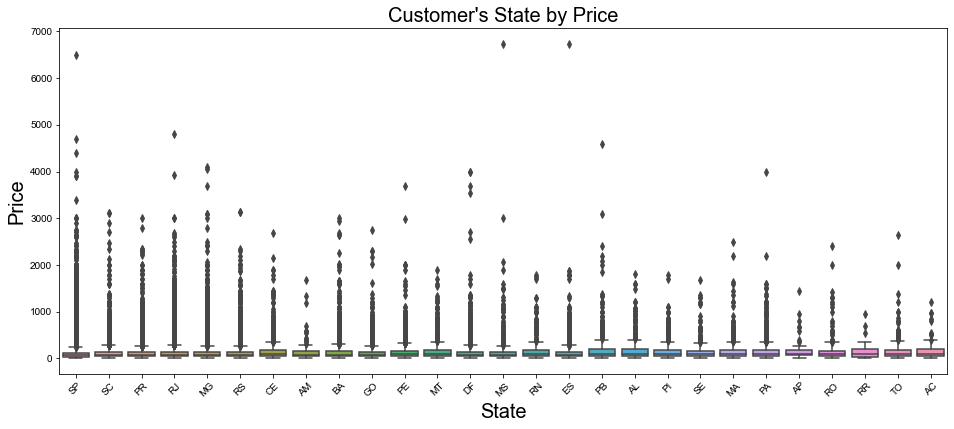

In [34]:
plt.figure(figsize=(35,14))

plt.subplot(221)
sns.set(font_scale=1.5) 
g2 = sns.boxplot(x='customer_state', y='price', 
                 data=df_train_state[df_train_state['price'] != -1])
g2.set_title("Customer's State by Price", fontsize=20)
g2.set_xlabel("State", fontsize=20)
g2.set_ylabel("Price", fontsize=20)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

plt.show()

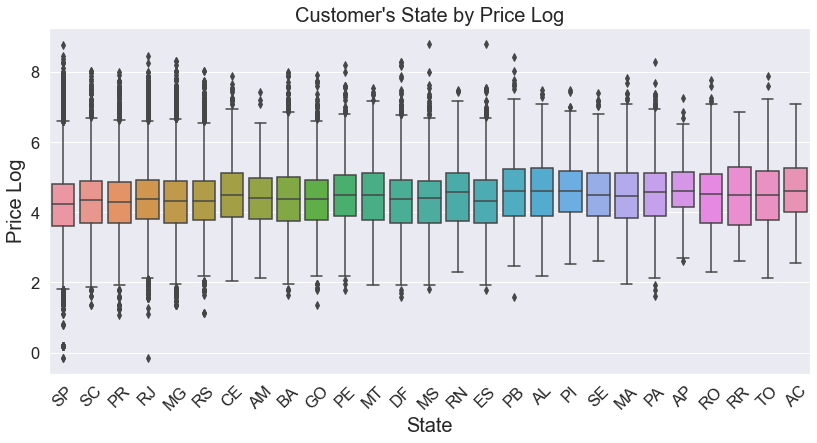

In [35]:
plt.figure(figsize=(30,14))
df_train_state['price_log'] = np.log(df_train_state['price'])

plt.subplot(221)
sns.set(font_scale=1.5) 
g2 = sns.boxplot(x='customer_state', y='price_log', 
                 data=df_train_state[df_train_state['price'] != -1])
g2.set_title("Customer's State by Price Log", fontsize=20)
g2.set_xlabel("State", fontsize=20)
g2.set_ylabel("Price Log", fontsize=20)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

plt.show()

In [36]:
plt.figure(figsize=(16,12))

g = sns.countplot(x='customer_state', data=df_train_state, orient='h', order=df_train['customer_state'].value_counts().index)
g.set_title("DISTRIBUIÇÃO DE CLIENTES POR ESTADO", fontsize=20)
g.set_xlabel("Estado", fontsize=17)
g.set_ylabel("Quantidade (%)", fontsize=17)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
sizes = []
total=len(df_train_state)

for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.1)

plt.show()


KeyError: 'customer_state'

<Figure size 1152x864 with 0 Axes>

https://github.com/letsdata/series-temporais-python/blob/main/series-temporais-python.ipynb